In [ ]:
!pip install oct-converter

In [2]:
import os 
import numpy as np 
import pandas as pd
import torch
import json
import cv2
from oct_converter.readers import BOCT
from pathlib import Path

import matplotlib.pyplot as plt 

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import gspread
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())




worksheet = gc.open('Monkey Data').sheet1
rows = worksheet.get_all_values()
data = pd.DataFrame.from_records(rows[1:])
data.columns = rows[0]

Mounted at /content/gdrive


In [3]:
def peek(array, rows=1, cols=4, axis=2, filepath=None, figsize=(12,3)):
  """ Plots a montage of the OCT volume. Optionally saves the plot if a filepath is provided.
  Args:
      oct :
      rows (int) : Number of rows in the plot.
      cols (int) : Number of columns in the plot.
      filepath (str): Location to save montage to.
  """
  n_images = rows * cols
  idxs = (np.linspace(0, array.shape[axis], n_images + 4)[2:-2]).astype(int)
  plt.figure(figsize=figsize)
  for i in range(n_images):
    idx = idxs[i]
    plt.subplot(rows, cols, i + 1)
    if axis == 0:
      plt.imshow(array[idx,:,:])
    elif axis == 1:
      plt.imshow(array[:,idx,:])
    elif axis == 2:
      plt.imshow(array[:,:,idx])
    plt.axis('off')
    plt.title('{}'.format(idx))

  plt.suptitle('OCT volume with shape {}'.format(array.shape))
  if filepath is not None:
    plt.savefig(filepath)
    plt.close()
  else:
    plt.show()
  return

In [72]:
def downsize(data, verbose=False):
  if verbose:
    print('Original data')
    peek(data) 

  tensor_full = torch.Tensor(cv2.convertScaleAbs(data, alpha=(255.0/65535.0)))
  if verbose:
    print('Convert to Torch tensor (uint16 to uint8, losing a bit of precision')
    peek(tensor_full)

  # idk why it keeps fucking up the axes
  reshaped = tensor_full.view(512, 512, 2048, 1, 1).transpose(0,2).transpose(0,4).transpose(1,3) # fuckery to keep the axes in place
  # building a grid to downsample in 3-D
  # i dont know why or how it works
  d = torch.linspace(-1, 1, 128)
  meshx, meshy, meshz = torch.meshgrid((torch.linspace(-1,1,512), d, d))
  grid = torch.stack((meshx, meshy, meshz), 3).unsqueeze(0)
  tensor_downsized = torch.nn.functional.grid_sample(reshaped, grid, align_corners=True).squeeze().swapaxes(0,2) # more fuckery to keep the axes in place
  if verbose:
    print('3-D downsized tensor via torch.nn.functional.grid_sample')
    peek(tensor_downsized)
  return tensor_downsized

# Example of downsized image

Original data


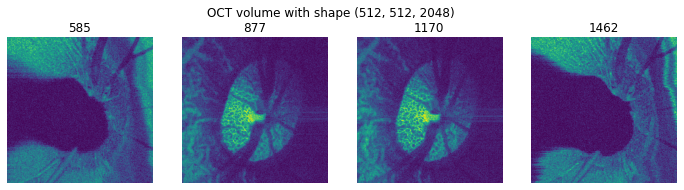

Convert to Torch tensor (uint16 to uint8, losing a bit of precision


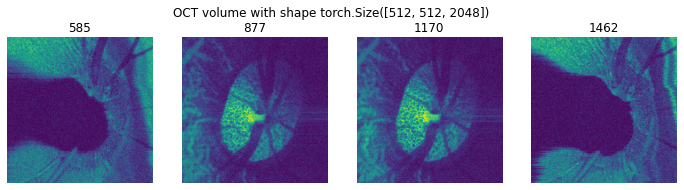

3-D downsized tensor via torch.nn.functional.grid_sample


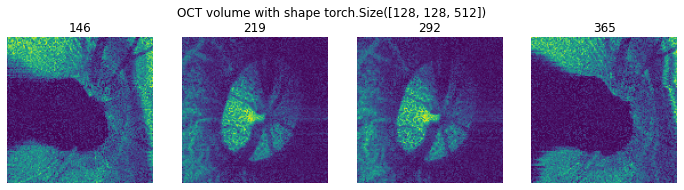

In [74]:
example = 'gdrive/My Drive/CDS Capstone Project/Data/OCTs/439.OCT'
boct = BOCT(example)
boct.read_oct_volume(diskbuffered=False)
data = boct.vol[0]
downsized = downsize(data, verbose=True)

# Scans are of varying quality and shape

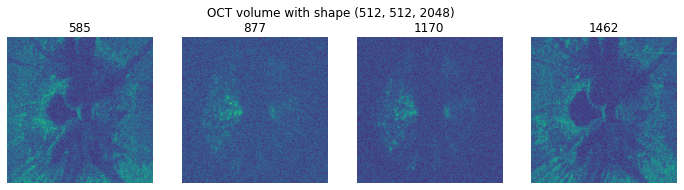

In [76]:
example = 'gdrive/My Drive/CDS Capstone Project/Data/OCTs/712.OCT'
boct = BOCT(example)
boct.read_oct_volume(diskbuffered=False)
peek(boct.vol[0])

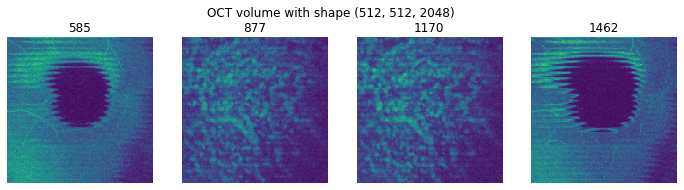

In [78]:
image_path = 'gdrive/My Drive/CDS Capstone Project/Data/OCTs/560.OCT'
boct = BOCT(image_path)
boct.read_oct_volume(diskbuffered=False)
peek(boct.vol[0])

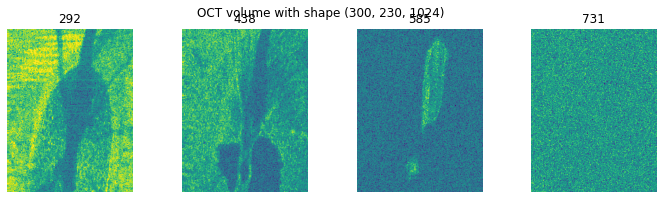

In [79]:
image_path = 'gdrive/My Drive/CDS Capstone Project/Data/OCTs/1020.OCT'
boct = BOCT(image_path)
boct.read_oct_volume(diskbuffered=False)
peek(boct.vol[0])

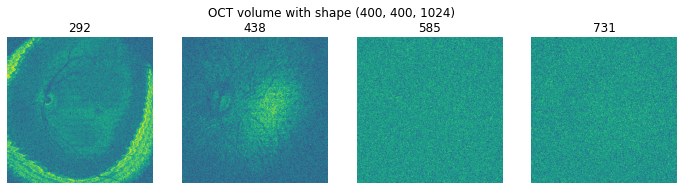

In [80]:
image_path = 'gdrive/My Drive/CDS Capstone Project/Data/OCTs/1002.OCT'
boct = BOCT(image_path)
boct.read_oct_volume(diskbuffered=False)
peek(boct.vol[0])

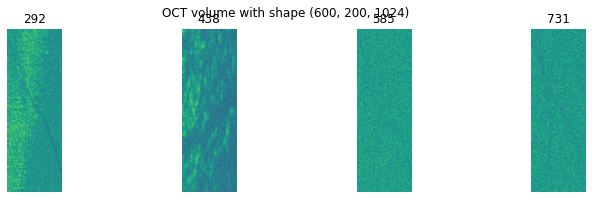

In [82]:
image_path = 'gdrive/My Drive/CDS Capstone Project/Data/OCTs/1012.OCT'
boct = BOCT(image_path)
boct.read_oct_volume(diskbuffered=False)
peek(boct.vol[0])

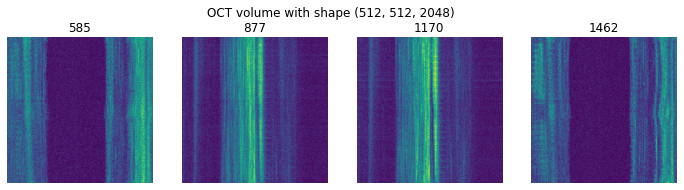

In [81]:
image_path = 'gdrive/My Drive/CDS Capstone Project/Data/OCTs/428.OCT'
boct = BOCT(image_path)
boct.read_oct_volume(diskbuffered=False)
peek(boct.vol[0])

# Process all OCTs
Downsize Torch tensors and save previews

In [ ]:
root_path = 'gdrive/My Drive/CDS Capstone Project/Data'
octs_dir = os.path.join(root_path, 'OCTs')
image_dir = os.path.join(root_path, 'image_samples')
tensor_dir = os.path.join(root_path, 'torch_arrays_128')
shapes_json = os.path.join(root_path, 'shapes.json')

octs = pd.Series(os.listdir(octs_dir))

# JSON to contain dimensions of each OCT
with open(shapes_json, 'r') as f: 
  shapes = json.load(f)

# print which we've already done
shapes

In [ ]:
# Process OCTs
for oct in octs: 
  oct_id = oct.strip('.OCT')
  image_path = os.path.join(octs_dir, oct)
  vis_orig_path = '{}/{}_orig.png'.format(image_dir, oct_id)
  vis_downsampled_path = '{}/{}_downsampled.png'.format(image_dir, oct_id)
  tensor_path = '{}/{}.pt'.format(tensor_dir, oct_id)

  # check if conversion is already done
  if os.path.exists(vis_orig_path):
    print('Already converted OCT {}, png can be found in {}. Skipping'.format(oct, vis_orig_path))
    continue 
  
  # read BOCT 
  print('Reading from {}'.format(image_path))
  boct = BOCT(image_path)
  boct.read_oct_volume(diskbuffered=False)
  shapes[oct] = boct.vol[0].shape
  print('Shape of image is {}'.format(shapes[oct]))

  # save Torch tensor downsampled
  if (shapes[oct][0] == shapes[oct][1]) & (shapes[oct][0] < shapes[oct][2]):
    print('Scan is valid shape. Converting to Torch array and saving in {}'.format(tensor_path))
    tensor_downsized = downsize(boct.vol[0])
    torch.save(tensor_downsized, tensor_path)
    peek(tensor_downsized, cols=6, figsize=(18,3), filepath=vis_downsampled_path)

  # save shapes json
  with open(shapes_json, 'w') as f:
    f.write(json.dumps(shapes))

  # save scan visualization
  peek(boct.vol[0], cols=6, figsize=(18,3), filepath=vis_orig_path)
  print('Saved visualization in {}'.format(vis_orig_path))
  print('')

Already converted OCT 703.OCT, png can be found in gdrive/My Drive/CDS Capstone Project/Data/image_samples/703_orig.png. Skipping
Already converted OCT 704.OCT, png can be found in gdrive/My Drive/CDS Capstone Project/Data/image_samples/704_orig.png. Skipping
Already converted OCT 705.OCT, png can be found in gdrive/My Drive/CDS Capstone Project/Data/image_samples/705_orig.png. Skipping
Already converted OCT 706.OCT, png can be found in gdrive/My Drive/CDS Capstone Project/Data/image_samples/706_orig.png. Skipping
Already converted OCT 707.OCT, png can be found in gdrive/My Drive/CDS Capstone Project/Data/image_samples/707_orig.png. Skipping
Already converted OCT 708.OCT, png can be found in gdrive/My Drive/CDS Capstone Project/Data/image_samples/708_orig.png. Skipping
Reading from gdrive/My Drive/CDS Capstone Project/Data/OCTs/709.OCT
Shape of image is (512, 512, 2048)
Scan is valid shape. Converting to Torch array and saving in gdrive/My Drive/CDS Capstone Project/Data/torch_arrays_1